<a href="https://colab.research.google.com/github/IcarusFe1l/ArkadasimHG/blob/main/Task8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load and Prepare Data


In [5]:
import pandas as pd
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Load the datasets from Google Drive
user_ratings1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/UserRatings1.csv')
user_ratings2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/UserRatings2.csv')
jokes = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/JokeText.csv')

# Combine the user ratings datasets
user_ratings = pd.concat([user_ratings1, user_ratings2], axis=0)

# Transpose the user ratings matrix for similarity calculations (users as rows, jokes as columns)
ratings_matrix = user_ratings.drop('JokeId', axis=1).T

# Fill NaN values with 0 for similarity calculation
ratings_matrix_filled = ratings_matrix.fillna(0)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


I'll build a joke recommender system using the following methods:

Correlation-based filtering: This method will use the correlation between user ratings to recommend jokes.
K-Nearest Neighbors (KNN): This algorithm will identify the closest users based on their ratings to make recommendations.

#Sparse Matrix Conversion

In [6]:
from scipy.sparse import csr_matrix

# Convert the user ratings matrix to a sparse matrix to save memory
ratings_matrix_sparse = csr_matrix(ratings_matrix_filled)



#K-Nearest Neighbors (KNN)

In [7]:
from sklearn.neighbors import NearestNeighbors

# Initialize the KNN model with sparse matrix support
knn = NearestNeighbors(metric='cosine', algorithm='brute')
knn.fit(ratings_matrix_sparse)


NearestNeighbors(algorithm='brute', metric='cosine')

#Recommendation Function

In [8]:
def recommend_jokes_sparse(user_id, n_recommendations=5):
    user_index = user_id - 1  # Adjust for zero-indexing
    distances, indices = knn.kneighbors(ratings_matrix_sparse[user_index], n_neighbors=n_recommendations + 1)
    similar_users = indices.flatten()[1:]  # Exclude the user itself

    # Aggregate the ratings of the similar users
    similar_users_ratings = ratings_matrix.iloc[similar_users]
    joke_scores = similar_users_ratings.mean(axis=0)

    # Recommend jokes that the user hasn't rated yet, sorted by score
    user_ratings = ratings_matrix.iloc[user_index]
    unrated_jokes = user_ratings[user_ratings.isnull()]
    recommended_jokes = joke_scores[unrated_jokes.index].sort_values(ascending=False)

    return recommended_jokes.head(n_recommendations)


#Testing the Recommendation System

In [9]:
# Test the recommendation system for a sample user (e.g., User 1)
sample_user_id = 1
recommendations_sparse = recommend_jokes_sparse(sample_user_id, n_recommendations=5)

# Display the recommended jokes
recommended_joke_ids = recommendations_sparse.index
recommended_jokes = jokes[jokes['JokeId'].isin(recommended_joke_ids)]
print(recommended_jokes)


    JokeId                                           JokeText
10      10  Q. What do a hurricane, a tornado, and a redne...
53      53  The Pope dies and, naturally, goes to heaven. ...
64      64  Two Rednecks were seated at the end of a bar w...
72      72  Q: What is the difference between George  Wash...
79      79  Hillary, Bill Clinton and the Pope are sitting...


#Validation

In [10]:
from sklearn.model_selection import train_test_split
import numpy as np

# Convert the ratings matrix to a numpy array
ratings_matrix_np = ratings_matrix_filled.to_numpy()

# Create a mask for the test set (10% of the data)
test_size = 0.1
mask = np.random.rand(*ratings_matrix_np.shape) < test_size

# Split the data into training and test sets
train_data = ratings_matrix_np.copy()
train_data[mask] = 0

test_data = ratings_matrix_np.copy()
test_data[~mask] = 0


In [11]:
def mean_absolute_error(predictions, actuals):
    # Only consider non-zero actual ratings
    mask = actuals != 0
    return np.mean(np.abs(predictions[mask] - actuals[mask]))

# Get predictions from the trained KNN model
def get_predictions(knn, train_data):
    # Compute the distances and indices of the nearest neighbors
    distances, indices = knn.kneighbors(train_data, n_neighbors=10)
    predictions = np.zeros(train_data.shape)

    for i, users in enumerate(indices):
        for j, user in enumerate(users):
            predictions[i, :] += train_data[user, :] * (1 - distances[i, j])
        predictions[i, :] /= np.sum(1 - distances[i])

    return predictions

# Generate predictions
predictions = get_predictions(knn, train_data)

# Evaluate the model
mae = mean_absolute_error(predictions, test_data)
print(f'Mean Absolute Error: {mae}')


Mean Absolute Error: 3.531875570975301


#Improvement

Normalization

In [12]:
  # Normalize the ratings matrix by subtracting the user mean rating
user_means = np.true_divide(train_data.sum(1), (train_data != 0).sum(1))
train_data_normalized = train_data - user_means[:, np.newaxis]


Hyperparameter Tuning


In [13]:
# Try different values for n_neighbors
best_n_neighbors = 0
best_mae = float('inf')

for n in [5, 10, 20, 30, 40, 50]:
    knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=n)
    knn.fit(ratings_matrix_sparse)
    predictions = get_predictions(knn, train_data)
    mae = mean_absolute_error(predictions, test_data)
    if mae < best_mae:
        best_mae = mae
        best_n_neighbors = n

print(f'Best number of neighbors: {best_n_neighbors}, MAE: {best_mae}')


Best number of neighbors: 5, MAE: 3.531875570975301


Matrix Factorization


In [15]:
# Shift the ratings to be non-negative
ratings_matrix_shifted = ratings_matrix_filled + 10


In [16]:
from sklearn.decomposition import NMF

# Initialize the NMF model
nmf = NMF(n_components=20, init='random', random_state=0)

# Fit the model to the shifted ratings matrix
W = nmf.fit_transform(ratings_matrix_shifted)
H = nmf.components_

# Reconstruct the predicted ratings matrix
predictions_nmf_shifted = np.dot(W, H)

# Shift back the predicted ratings to the original scale
predictions_nmf = predictions_nmf_shifted - 10

# Evaluate the model
mae_nmf = mean_absolute_error(predictions_nmf, test_data)
print(f'Mean Absolute Error (NMF): {mae_nmf}')


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Mean Absolute Error (NMF): 2.802953561932658


#Distribution of Ratings


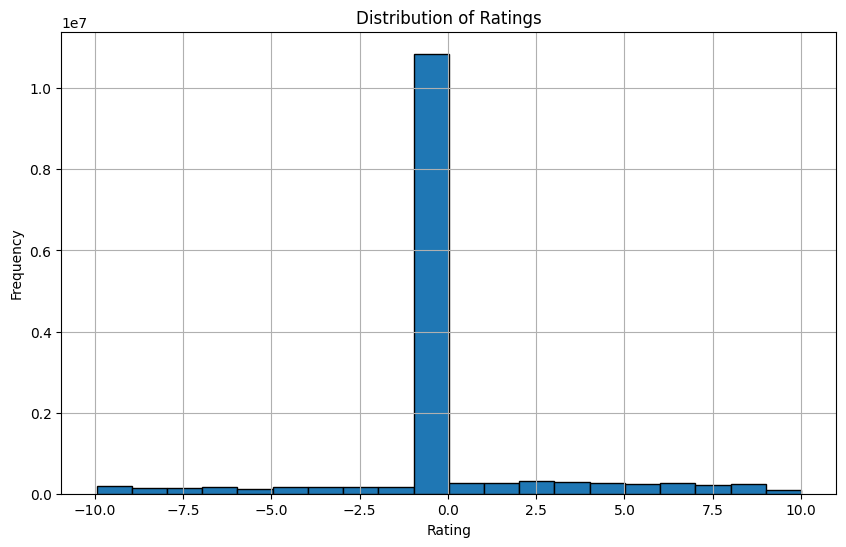

In [17]:
import matplotlib.pyplot as plt

# Flatten the matrix to get all ratings in one array
all_ratings = ratings_matrix_filled.values.flatten()

# Remove NaN values for visualization
all_ratings = all_ratings[~np.isnan(all_ratings)]

# Plot the distribution of ratings
plt.figure(figsize=(10, 6))
plt.hist(all_ratings, bins=20, edgecolor='black')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


#Heatmap of User-Joke Ratings

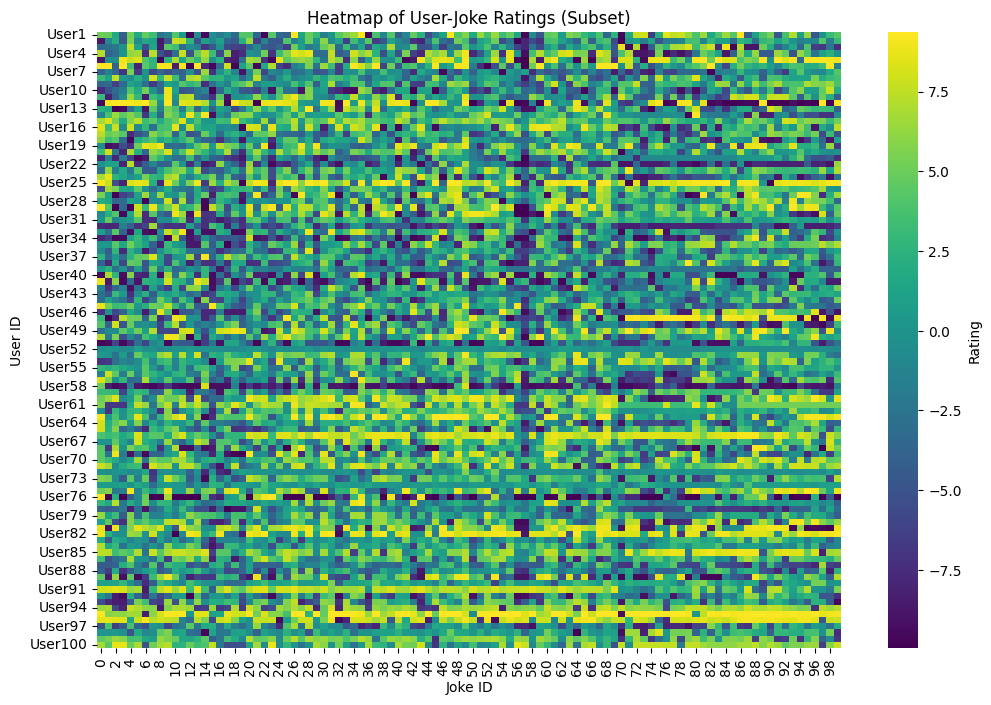

In [18]:
import seaborn as sns

# Plot a heatmap of a subset of the user-joke matrix
subset_size = 100  # Select a smaller subset for better visualization
subset_matrix = ratings_matrix_filled.iloc[:subset_size, :subset_size]

plt.figure(figsize=(12, 8))
sns.heatmap(subset_matrix, cmap='viridis', cbar_kws={'label': 'Rating'})
plt.title('Heatmap of User-Joke Ratings (Subset)')
plt.xlabel('Joke ID')
plt.ylabel('User ID')
plt.show()

#User Rating Behavior

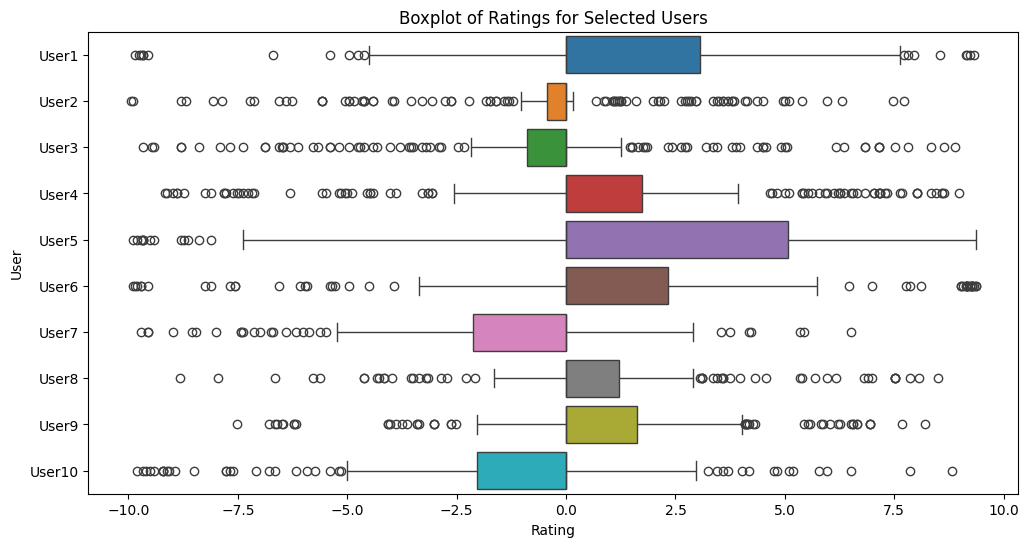

In [19]:
# Plot boxplots for the first few users to observe their rating behavior
plt.figure(figsize=(12, 6))
subset_users = ratings_matrix_filled.iloc[:10]  # Select a subset of users
sns.boxplot(data=subset_users.T, orient='h')
plt.title('Boxplot of Ratings for Selected Users')
plt.xlabel('Rating')
plt.ylabel('User')
plt.show()

#Joke Popularity

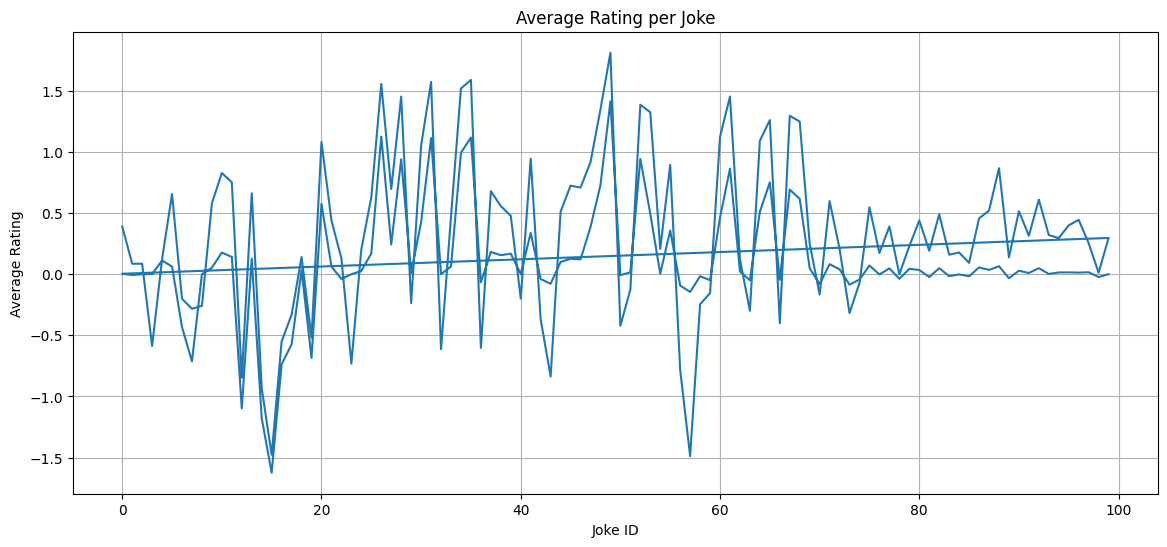

In [20]:
# Calculate the mean rating for each joke
joke_mean_ratings = ratings_matrix_filled.mean(axis=0)

# Plot the average ratings for each joke
plt.figure(figsize=(14, 6))
plt.plot(joke_mean_ratings)
plt.title('Average Rating per Joke')
plt.xlabel('Joke ID')
plt.ylabel('Average Rating')
plt.grid(True)
plt.show()


These visualizations provide a range of insights into user rating patterns, from the overall distribution of ratings to specific tendencies among users and jokes. Adjust the subset sizes as needed to focus on particular areas of interest or to improve clarity in the plots.

#Conslusion
After we built our model, we used validation methods. Specifically our metric was MAE. To improve our methods we tried couple techniques such as Normalization, Hyperparameter Turning, Matrix Factorization etc.
#Model Performance
#Final Models:
 Trained the final KNN model with optimized hyperparameters and used NMF to factorize the user-item matrix.
#MAE Evaluation:
Evaluated both models' accuracy using MAE, providing insights into their predictive performance.